In [ ]:
# imports
from google.colab import drive
drive.mount('/content/drive')
project_dir = "drive/MyDrive/uwsagp/"

import matplotlib.pyplot as plt
import random
import torch
import pickle
from drive.MyDrive.uwsagp.src.modules import init_model, predict_boxes, epoch_loss
from drive.MyDrive.uwsagp.src.visualization import draw_boxes, viszualize_images
from drive.MyDrive.uwsagp.src.data_handling import load_data
from torchvision.transforms import Resize
from PIL import Image
import time

Mounted at /content/drive


In [ ]:
# hyperparameters
device = "cuda"
objectness_weight = 2  # 2 works well
rpn_weight = 2  # 1 works well
lr = 0.00005
epochs = 10
lr_decay_epochs = 10
lr_decay_factor = 0.95
img_squeeze = 10
confidence_thresh = 0.05

In [ ]:
# data preprocessing
imgs, boxes, img_paths = load_data(annot_path=project_dir + "data/litter/annotations.xml", 
                                   img_squeeze=img_squeeze, 
                                   clean_dir=project_dir + "data/clean")

combined = list(zip(img_paths, imgs, boxes))
random.seed(42)
random.shuffle(combined)
train = combined[int(len(imgs) * 0.1):]
test = combined[:int(len(imgs) * 0.1)]
with open(project_dir + 'data/train.pkl', 'wb') as f:
    pickle.dump(train, f)
with open(project_dir + 'data/test.pkl', 'wb') as f:
    pickle.dump(test, f)

In [ ]:
# training
with open(project_dir + 'data/train.pkl', 'rb') as f:
    train = pickle.load(f)
with open(project_dir + 'data/test.pkl', 'rb') as f:
    test = pickle.load(f)

img_paths_train, imgs_train, boxes_gt_train = zip(*train)
img_paths_test, imgs_test, boxes_gt_test = zip(*test)

model = init_model().to(device)

# training with stochastic adam
model.train()
adam = torch.optim.Adam(params=model.parameters(), lr=lr)
epoch_losses_train = []
epoch_losses_test = []

# evaluation before training
epoch_losses_train.append(torch.tensor(losses_train).mean().item())
epoch_losses_test.append(torch.tensor(losses_test).mean().item())
best_loss_test = epoch_losses_test[-1]
print("train loss:", epoch_losses_train[-1])
print("test loss:", epoch_losses_test[-1])

# training
for epoch in range(epochs):
    print("epoch", epoch + 1)
    if (epoch > 0) and epoch % lr_decay_epochs:
        adam.param_groups[0]['lr'] = adam.param_groups[0]['lr'] * lr_decay_factor
    for i in range(len(imgs_train)):
        img = imgs_train[i].to(device)
        labels = torch.zeros(size=[len(boxes_gt_train[i])], dtype=torch.int64)  
        target = [{"boxes": torch.tensor(boxes_gt_train[i]).to(device), 
                   "labels": labels.to(device)}]
        out = model(img, target)
        loss = out["loss_box_reg"] + objectness_weight * out["loss_objectness"] + rpn_weight * out["loss_rpn_box_reg"]
        loss.backward()  # accumulate gradients
        adam.step()  # update model parameters
        adam.zero_grad()  # reset gradients

    losses_test = epoch_loss(imgs=imgs_test, 
                         boxes_gt=boxes_gt_test, 
                         model=model, 
                         objectness_weight=objectness_weight, 
                         rpn_weight=rpn_weight, 
                         device=device)
    losses_train = epoch_loss(imgs=imgs_train, 
                              boxes_gt=boxes_gt_train, 
                              model=model, 
                              objectness_weight=objectness_weight, 
                              rpn_weight=rpn_weight, 
                              device=device)
    epoch_losses_train.append(torch.tensor(losses_train).mean().item())
    epoch_losses_test.append(torch.tensor(losses_test).mean().item())
    print("train loss:", epoch_losses_train[-1])
    print("test loss:", epoch_losses_test[-1])

    # checkpoint model
    if epoch_losses_test[-1] < best_loss_test:
        torch.save(model, project_dir + "monitoring/model.pkl")
        best_loss_test = epoch_losses_test[-1]

    # shuffle training data for next epoch
    combined = list(zip(imgs_train, boxes_gt_train, img_paths_train))
    random.seed(epoch)
    random.shuffle(combined)
    imgs_train, boxes_gt_train, img_paths_train = zip(*combined)

# save
with open(project_dir + f'monitoring/epoch_losses_train.pkl', 'wb') as f:
        pickle.dump(epoch_losses_train, f)
with open(project_dir + f'monitoring/epoch_losses_test.pkl', 'wb') as f:
        pickle.dump(epoch_losses_test, f)

train loss: 0.10446082055568695
test loss: 0.10797040164470673
epoch 1


<ipython-input-8-5fc1d7fc040a>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = [{"boxes": torch.tensor(boxes_gt_train[i]).to(device),


train loss: 0.1600811928510666
test loss: 0.1579769253730774
epoch 2
train loss: 0.013342675752937794
test loss: 0.014967177994549274
epoch 3
train loss: 0.008099522441625595
test loss: 0.013373549096286297
epoch 4
train loss: 0.007295119576156139
test loss: 0.011918395757675171
epoch 5
train loss: 0.006318783387541771
test loss: 0.01181956846266985
epoch 6
train loss: 0.002660867292433977
test loss: 0.014462027698755264
epoch 7
train loss: 0.0030086638871580362
test loss: 0.016388041898608208
epoch 8
train loss: 0.0027618873864412308
test loss: 0.012813789770007133
epoch 9
train loss: 0.0026332091074436903
test loss: 0.01946912333369255
epoch 10
train loss: 0.0028848140500485897
test loss: 0.019037360325455666


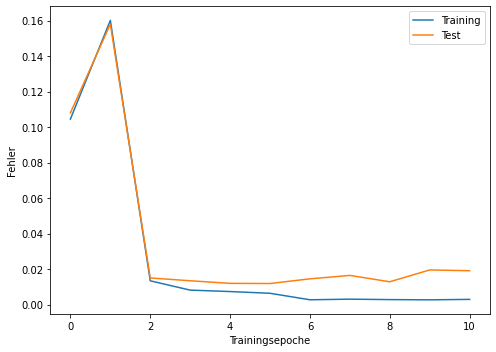

In [ ]:
# visualize epoch losses
with open(project_dir + f'monitoring/epoch_losses_train.pkl', 'rb') as f:
        epoch_losses_train = pickle.load(f)

with open(project_dir + f'monitoring/epoch_losses_test.pkl', 'rb') as f:
        epoch_losses_test = pickle.load(f)
 

fig = plt.figure(figsize=(7,5))
plt.plot(range(len(epoch_losses_train)), epoch_losses_train, label="Training")
plt.plot(range(len(epoch_losses_test)), epoch_losses_test, label="Test")
plt.legend()
plt.xlabel('Trainingsepoche')
plt.ylabel('Fehler')
plt.tight_layout()
plt.savefig(project_dir + "monitoring/losses.png")

tensor([], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([0.0550], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([0.8798, 0.7611, 0.7499, 0.2927, 0.1468, 0.1447, 0.1381, 0.1130, 0.0980,
        0.0819, 0.0787, 0.0745, 0.0686, 0.0673, 0.0627, 0.0547],
       device='cuda:0', grad_fn=<IndexBackward0>)
tensor([], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([0.4016, 0.2219, 0.2044, 0.1201, 0.1016, 0.0901, 0.0886, 0.0691, 0.0564,
        0.0551], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([0.0832, 0.0780, 0.0645, 0.0642], device='cuda:0',
       grad_fn=<IndexBackward0>)
tensor([0.6300, 0.5192, 0.3646, 0.1252, 0.0963, 0.0903, 0.0545],
       device='cuda:0', grad_fn=<IndexBackward0>)
tensor([0.1234, 0.0927], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([0.6100, 0.2617, 0.2260, 0.2243, 0.1472, 0.1230, 0.0857, 0.0642, 0.0618,
        0.0513, 0.0504], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([0.1219, 0.1091, 0.1081, 0.0841, 0.0794, 0.0704, 0.0571, 0.0502],
  

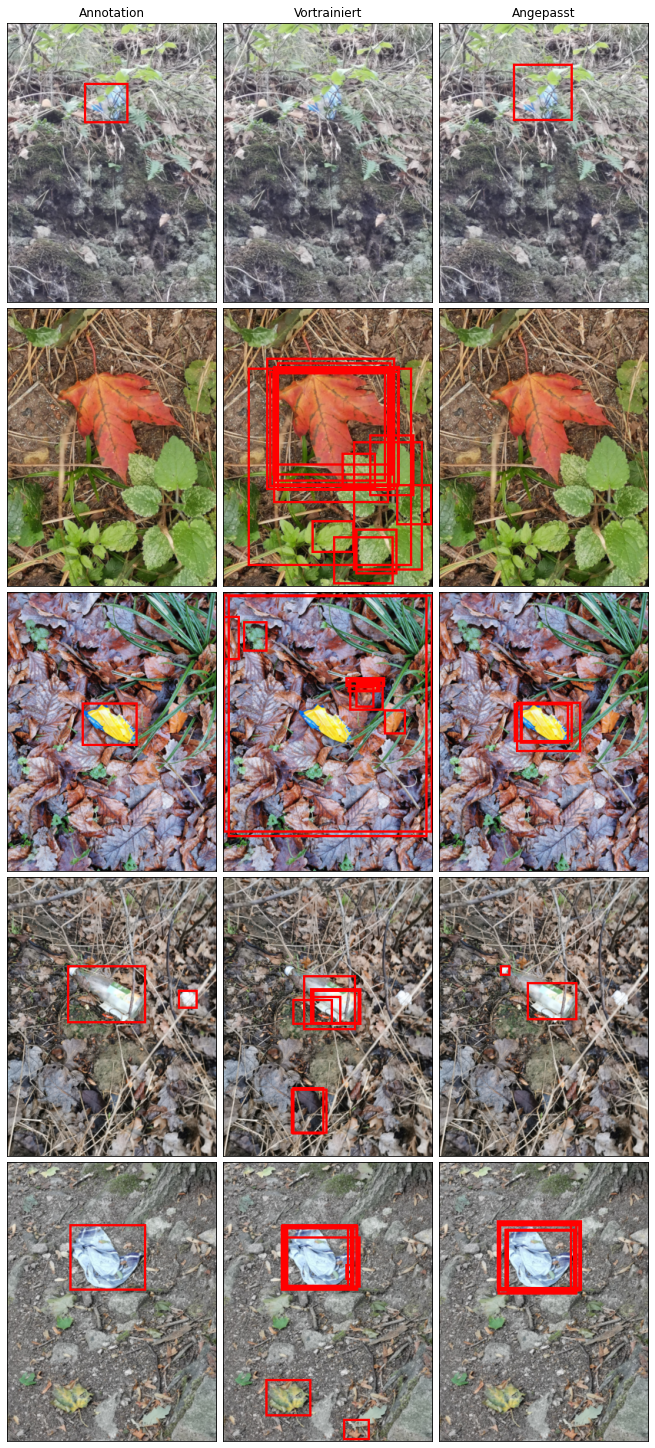

In [ ]:
# visualize some test images
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(9, 20), layout="constrained")
axs[0, 0].set_title('Annotation')
axs[0, 1].set_title('Vortrainiert')
axs[0, 2].set_title('Angepasst')
resize = Resize(size=int(2736 / img_squeeze))
confidence_thresh = 0.01

img_paths_test, imgs_test, boxes_gt_test = zip(*test)
model_pretrained = init_model().to(device)
model = torch.load(project_dir + "monitoring/model.pkl").to(device)

for j, i in enumerate([17, 7, 1, 22, 3]): 
    # ground truth
    img = resize(Image.open(img_paths_test[i]))
    image_gt = draw_boxes(boxes=boxes_gt_test[i], image=img)

    # model pretrained
    boxes = predict_boxes(input_tensor=imgs_test[i].to(device), model=model_pretrained, thresh=confidence_thresh)
    img = resize(Image.open(img_paths_test[i]))
    image_pretrained = draw_boxes(boxes=boxes, image=img)

    # model
    boxes = predict_boxes(input_tensor=imgs_test[i].to(device), model=model, thresh=confidence_thresh)
    img = resize(Image.open(img_paths_test[i]))
    image_after = draw_boxes(boxes=boxes, image=img)
    axs[j, 0].imshow(image_gt)
    axs[j, 1].imshow(image_pretrained)
    axs[j, 2].imshow(image_after)

for ax in axs.flat:
    ax.set(xticks=[], xticklabels=[])
    ax.set(yticks=[], yticklabels=[])

# Show the plot
plt.savefig(project_dir + "monitoring/all.png")